In [58]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

import os
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import math
import random

from FEANet.mesh import MeshHandler
from FEANet.geo import Geometry
from FEANet.jacobi import JacobiBlock
from FEANet.model import KNet, FNet
from FEANet.multigrid import MultiGrid

from Utils import plot
from Data.dataset import RHSDataSet

In [59]:
linear_tensor_R = torch.asarray([[1, 2, 1],
                                 [2, 4, 2],
                                 [1, 2, 1]], dtype=torch.float32) / 16.0
linear_tensor_P = torch.asarray([[1, 2, 1],
                                 [2, 4, 2],
                                 [1, 2, 1]], dtype=torch.float32) / 4.0
linear_ratio = torch.asarray([4.,1.], dtype=torch.float32)

In [60]:
n = 2**4
model = MultiGrid(n, linear_tensor_R, linear_tensor_P, linear_ratio)

In [61]:
model_dir = 'Model/multigrid_rhs_qm'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
    
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
mlist = list(model.parameters())
print('Ratio:', mlist[0][:])
print('Restriction kernel:', mlist[1][0][0])
print('Restriction kernel shape:', mlist[1].shape)
print('Interpolation kernel:', mlist[2][0][0])
print('Interpolation kernel shape:', mlist[2].shape)

Ratio: tensor([4., 1.])
Restriction kernel: tensor([[0.0625, 0.1250, 0.0625],
        [0.1250, 0.2500, 0.1250],
        [0.0625, 0.1250, 0.0625]], grad_fn=<SelectBackward0>)
Restriction kernel shape: torch.Size([1, 16, 3, 3])
Interpolation kernel: tensor([[0.2500, 0.5000, 0.2500],
        [0.5000, 1.0000, 0.5000],
        [0.2500, 0.5000, 0.2500]], grad_fn=<SelectBackward0>)
Interpolation kernel shape: torch.Size([16, 1, 3, 3])


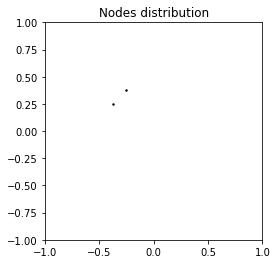

In [62]:
kernel_i = 12
mesh = MeshHandler(nnode_edge = n+1, outfile="Results/plate_mesh.vtk")
plot.plot_pattern(mesh, key=kernel_i)

Text(0.5, 0, 'epoch')

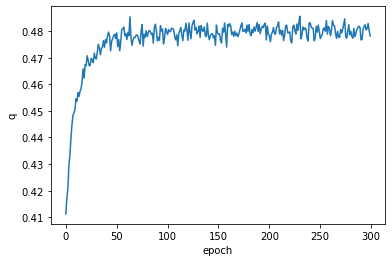

In [63]:
# load the training loss
model_name = 'model_multigrid_interface_kernel'+str(kernel_i)
qm_train = np.load(os.path.join(model_dir,model_name+'.npy'))
plt.plot(qm_train)
plt.ylabel('q')
plt.xlabel('epoch')

In [64]:
# import the learned model
model.load_state_dict(torch.load(os.path.join(model_dir,model_name+'.pth')))

<All keys matched successfully>

In [65]:
print('Learned parameters:')
print('Ratio:', mlist[0][:])
print('Restriction kernel:', mlist[1][0][kernel_i])
print('Interpolation kernel:', mlist[2][kernel_i][0])

print()

print('Previous parameters:')
print('Ratio:', mlist[0][:])
print('Restriction kernel:', mlist[1][0][kernel_i-1])
print('Interpolation kernel:', mlist[2][kernel_i-1][0])

Learned parameters:
Ratio: tensor([4., 1.])
Restriction kernel: tensor([[-0.7691,  0.3702,  0.2362],
        [ 0.3732,  0.2500,  0.3662],
        [ 0.2361,  0.3684, -0.3561]], grad_fn=<SelectBackward0>)
Interpolation kernel: tensor([[0.2668, 0.5094, 0.2778],
        [0.5096, 0.9845, 0.5173],
        [0.2777, 0.5171, 0.3441]], grad_fn=<SelectBackward0>)

Previous parameters:
Ratio: tensor([4., 1.])
Restriction kernel: tensor([[0.0625, 0.1250, 0.0625],
        [0.1250, 0.2500, 0.1250],
        [0.0625, 0.1250, 0.0625]], grad_fn=<SelectBackward0>)
Interpolation kernel: tensor([[0.2500, 0.5000, 0.2500],
        [0.5000, 1.0000, 0.5000],
        [0.2500, 0.5000, 0.2500]], grad_fn=<SelectBackward0>)
